**Chapter 11 – Training Deep Neural Networks**

_This notebook contains all the sample code and solutions to the exercises in chapter 11._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/11_training_deep_neural_networks.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [3]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [4]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

2025-08-24 19:54:05.843192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-24 19:54:05.843249: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-24 19:54:05.843289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-24 19:54:05.851981: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [5]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/deep` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [6]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "deep"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Vanishing/Exploding Gradients Problem

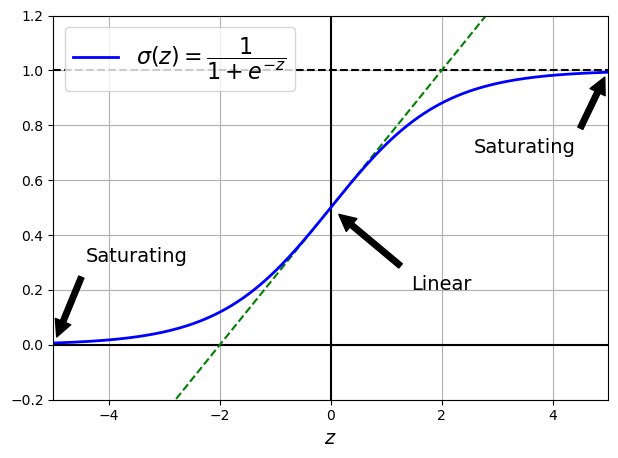

In [5]:
# extra code – this cell generates and saves Figure 11–1

import numpy as np

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')
plt.plot(z, sigmoid(z), "b-", linewidth=2,
         label=r"$\sigma(z) = \dfrac{1}{1+e^{-z}}$")
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props,
             fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props,
             fontsize=14, ha="center")
plt.grid(True)
plt.axis([-5, 5, -0.2, 1.2])
plt.xlabel("$z$")
plt.legend(loc="upper left", fontsize=16)

save_fig("sigmoid_saturation_plot")
plt.show()

## Xavier and He Initialization

... For controlling how connection weights for neuron links are initialised (which can be done per-layer)

In [6]:
dense = tf.keras.layers.Dense(
    50,
    activation="relu",
    kernel_initializer="he_normal"  # <- so, by default Keras uses the Golrot *connection weight initialisation* strategy with a uniform distribution. We can change the connection weights initialisation method by using this `kernel_initializer` parameter in Keras.
    # We can also use "he_uniform" for HE Initialisatoin aka Kaiming initialization using the uniform distribution.
    # There's both Normal and Uniform versions of all of these initialisers (book p. 360)
)

In [7]:
he_avg_init = tf.keras.initializers.VarianceScaling(
    scale=2., # ... Probably scale the standard uniform distribution (range) by two?
    mode="fan_avg", # Use fan_avg and not fan_in or w/e
    distribution="uniform" # <- Uniform distribution
)

dense = tf.keras.layers.Dense(
    50,
    activation="sigmoid",
    kernel_initializer=he_avg_init  # <- alternatively we can provide our own initialiser object, which allows us to specify more custom configurations
)

## Nonsaturating Activation Functions

### Leaky ReLU

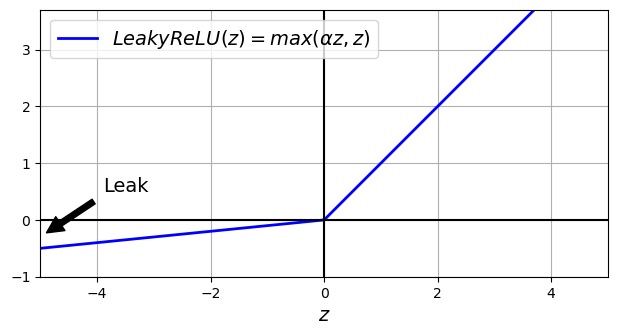

In [8]:
# extra code – this cell generates and saves Figure 11–2

def leaky_relu(z, alpha):
    return np.maximum(alpha * z, z)

z = np.linspace(-5, 5, 200)
plt.plot(z, leaky_relu(z, 0.1), "b-", linewidth=2, label=r"$LeakyReLU(z) = max(\alpha z, z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-1, 3.7], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.3), arrowprops=props,
             fontsize=14, ha="center")
plt.xlabel("$z$")
plt.axis([-5, 5, -1, 3.7])
plt.gca().set_aspect("equal")
plt.legend()

save_fig("leaky_relu_plot")
plt.show()

In [9]:
# Leaky ReLU, as in graph above. Alpha controls the slope of the line in ]-inf, 0]
leaky_relu = tf.keras.layers.LeakyReLU(
    alpha=0.2 # defaults to alpha=0.3
)

dense = tf.keras.layers.Dense(
    50,
    activation=leaky_relu,  # bring your own activation function (similar to how we could provide our own kernel_initialiser above to control the behaviour)
    kernel_initializer="he_normal"  # <- we should use HE connection weight initialisation with this one. Either Normal or Uniform.
)

In [10]:
# equivalent to above. Which one you uses makes no difference.
model = tf.keras.models.Sequential([
    # [...]  # more layers
    tf.keras.layers.Dense(50, kernel_initializer="he_normal"),  # no activation
    tf.keras.layers.LeakyReLU(alpha=0.2),  # activation as a separate layer
    # [...]  # more layers
])

2025-08-23 13:24:24.251140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-23 13:24:24.266998: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-23 13:24:24.267027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-23 13:24:24.268111: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-23 13:24:24.268138: I tensorflow/compile

### ELU

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer, and use He initialization:

In [11]:
dense = tf.keras.layers.Dense(
    50,
    activation="elu", # <- how to use the ELU activation function
    kernel_initializer="he_normal"
)

### SELU

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too, and other constraints are respected, as explained in the book). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

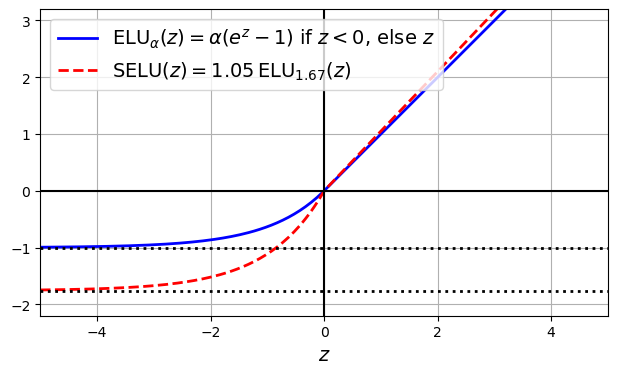

In [12]:
# extra code – this cell generates and saves Figure 11–3

from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1 / np.sqrt(2)) * np.exp(1 / 2) - 1)
scale_0_1 = (
    (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e))
    * np.sqrt(2 * np.pi)
    * (
        2 * erfc(np.sqrt(2)) * np.e ** 2
        + np.pi * erfc(1 / np.sqrt(2)) ** 2 * np.e
        - 2 * (2 + np.pi) * erfc(1 / np.sqrt(2)) * np.sqrt(np.e)
        + np.pi
        + 2
    ) ** (-1 / 2)
)

def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

z = np.linspace(-5, 5, 200)
plt.plot(z, elu(z), "b-", linewidth=2, label=r"ELU$_\alpha(z) = \alpha (e^z - 1)$ if $z < 0$, else $z$")
plt.plot(z, selu(z), "r--", linewidth=2, label=r"SELU$(z) = 1.05 \, $ELU$_{1.67}(z)$")
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k:', linewidth=2)
plt.plot([-5, 5], [-1.758, -1.758], 'k:', linewidth=2)
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-5, 5, -2.2, 3.2])
plt.xlabel("$z$")
plt.gca().set_aspect("equal")
plt.legend()

save_fig("elu_selu_plot")
plt.show()

Using SELU is straightforward:

In [13]:
dense = tf.keras.layers.Dense(
    50,
    activation="selu",  # <- same as before
    kernel_initializer="lecun_normal"  # ditto
)

**Extra material – an example of a self-regularized network using SELU**

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [14]:
tf.random.set_seed(42)
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="selu",
                                    kernel_initializer="lecun_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [11]:
fashion_mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist
X_train, y_train = X_train_full[:-5000], y_train_full[:-5000]
X_valid, y_valid = X_train_full[-5000:], y_train_full[-5000:]
X_train, X_valid, X_test = X_train / 255, X_valid / 255, X_test / 255

In [17]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

In [18]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [19]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5


2025-08-23 13:24:30.160423: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x771344060460 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-23 13:24:30.160446: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-08-23 13:24:30.176928: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-08-23 13:24:30.204493: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 [==============================] - 41s 20ms/step - loss: 1.0957 - accuracy: 0.5992 - val_loss: 0.7496 - val_accuracy: 0.7402
Epoch 2/5
1719/1719 [==============================] - 31s 18ms/step - loss: 0.6456 - accuracy: 0.7738 - val_loss: 0.5880 - val_accuracy: 0.7878
Epoch 3/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5485 - accuracy: 0.8085 - val_loss: 0.5232 - val_accuracy: 0.8238
Epoch 4/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5003 - accuracy: 0.8265 - val_loss: 0.4760 - val_accuracy: 0.8432
Epoch 5/5
1719/1719 [==============================] - 33s 19ms/step - loss: 0.5022 - accuracy: 0.8298 - val_loss: 0.4797 - val_accuracy: 0.8242


The network managed to learn, despite how deep it is. Now look at what happens if we try to use the ReLU activation function instead:

In [20]:
tf.random.set_seed(42)

In [21]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[28, 28]))
for layer in range(100):
    model.add(tf.keras.layers.Dense(100, activation="relu",
                                    kernel_initializer="he_normal"))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

In [22]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

In [23]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 41s 20ms/step - loss: 1.9999 - accuracy: 0.2446 - val_loss: 1.6516 - val_accuracy: 0.3780
Epoch 2/5
1719/1719 [==============================] - 37s 21ms/step - loss: 1.5335 - accuracy: 0.3780 - val_loss: 1.5607 - val_accuracy: 0.3302
Epoch 3/5
1719/1719 [==============================] - 37s 21ms/step - loss: 1.1347 - accuracy: 0.5199 - val_loss: 0.9456 - val_accuracy: 0.6288
Epoch 4/5
1719/1719 [==============================] - 35s 20ms/step - loss: 0.8804 - accuracy: 0.6462 - val_loss: 0.7603 - val_accuracy: 0.6998
Epoch 5/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.8031 - accuracy: 0.6746 - val_loss: 0.8269 - val_accuracy: 0.6708


Not great at all, we suffered from the vanishing/exploding gradients problem.

### GELU, Swish and Mish

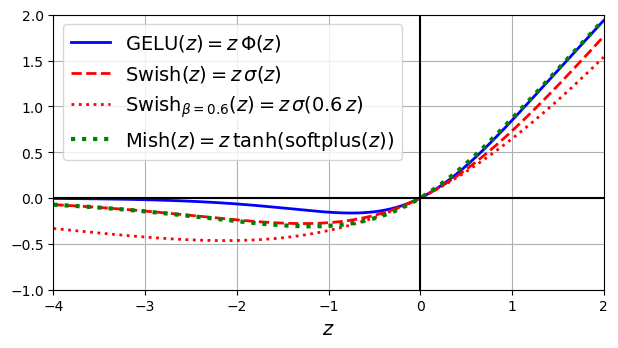

In [24]:
# extra code – this cell generates and saves Figure 11–4

def swish(z, beta=1):
    return z * sigmoid(beta * z)

def approx_gelu(z):
    return swish(z, beta=1.702)

def softplus(z):
    return np.log(1 + np.exp(z))

def mish(z):
    return z * np.tanh(softplus(z))

z = np.linspace(-4, 2, 200)

beta = 0.6
plt.plot(z, approx_gelu(z), "b-", linewidth=2,
         label=r"GELU$(z) = z\,\Phi(z)$")
plt.plot(z, swish(z), "r--", linewidth=2,
         label=r"Swish$(z) = z\,\sigma(z)$")
plt.plot(z, swish(z, beta), "r:", linewidth=2,
         label=fr"Swish$_{{\beta={beta}}}(z)=z\,\sigma({beta}\,z)$")
plt.plot(z, mish(z), "g:", linewidth=3,
         label=fr"Mish$(z) = z\,\tanh($softplus$(z))$")
plt.plot([-4, 2], [0, 0], 'k-')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.axis([-4, 2, -1, 2])
plt.gca().set_aspect("equal")
plt.xlabel("$z$")
plt.legend(loc="upper left")

save_fig("gelu_swish_mish_plot")
plt.show()

# Batch Normalization

In [25]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [26]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.BatchNormalization(),  # <- in the first layer! (Adding this here by itself, without adding it to the hidden layers, would be equivalent to using a regular Normalization layer, other than requiring .adapt() to be called if you use a Normalization() layer)
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),  # <- ... and then also after every hidden layer. (Or before would work too)
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),  # <- ... so as above we need to add it after the 2nd hidden layer here too
    tf.keras.layers.Dense(10, activation="softmax") # <- (and then obviously we don't need it after in the output layer)
])

In [27]:
model.summary()
# each BN layer adds four params per input:
# - output scale parameter, output shift parameter (both trainable in the sense of being touched by backprop)
# + the means and standard deviations (not touched by backprop, hence displayed as "non-trainable" in this output)
# this gives 4 x 784 = 3136 in the `batch_normalization` layer (784 is the img size as a flat array)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 batch_normalization (Batch  (None, 784)               3136      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 batch_normalization_1 (Bat  (None, 300)               1200      
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 batch_normalization_2 (Bat  (None, 100)               4

In [28]:
[(var.name, var.trainable) for var in model.layers[1].variables] # as above, the gama (output scale) and beta (output shift) params are trainable (by backprop),
# but the moving mean and moving variance are not (by backprop, even though they are "learned" during training in a certain sense, just not via backprop)
# ... the mean and variance that are "learned" here are used in the inference stage.

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [29]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 10s 5ms/step - loss: 0.5537 - accuracy: 0.8070 - val_loss: 0.4075 - val_accuracy: 0.8466
Epoch 2/2
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4065 - accuracy: 0.8562 - val_loss: 0.3679 - val_accuracy: 0.8634


Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [30]:
# extra code - clear the name counters and set the random seed
tf.keras.backend.clear_session()
tf.random.set_seed(42)

In [31]:
# How to do it before like the authors of this strategy suggest.
# (Which option will actually work better varies by your dataset)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [32]:
# extra code – just show that the model works! 😊
model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd",
              metrics=["accuracy"])
model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 8s 4ms/step - loss: 0.6016 - accuracy: 0.7985 - val_loss: 0.4312 - val_accuracy: 0.8454
Epoch 2/2
1719/1719 [==============================] - 8s 5ms/step - loss: 0.4251 - accuracy: 0.8525 - val_loss: 0.3789 - val_accuracy: 0.8652


## Gradient Clipping

All `tf.keras.optimizers` accept `clipnorm` or `clipvalue` arguments:

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0) # <- this one can change the direction of the gradient vector
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

In [ ]:
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0) # <- this one is a normalised clip that will preserve the direction (think normalisation in graphics contexts)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for T-shirts/tops and pullovers (classes 0 and 2).
* `X_train_B`: a much smaller training set of just the first 200 images of T-shirts/tops and pullovers.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (trousers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots) are somewhat similar to classes in set B (T-shirts/tops and pullovers). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the chapter 14).

In [36]:
# extra code – split Fashion MNIST into tasks A and B, then train and save
#              model A to "my_model_A".

pos_class_id = class_names.index("Pullover")
neg_class_id = class_names.index("T-shirt/top")

def split_dataset(X, y):
    y_for_B = (y == pos_class_id) | (y == neg_class_id)
    y_A = y[~y_for_B]
    y_B = (y[y_for_B] == pos_class_id).astype(np.float32)
    old_class_ids = list(set(range(10)) - set([neg_class_id, pos_class_id]))
    for old_class_id, new_class_id in zip(old_class_ids, range(8)):
        y_A[y_A == old_class_id] = new_class_id  # reorder class ids for A
    return ((X[~y_for_B], y_A), (X[y_for_B], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

tf.random.set_seed(42)

model_A = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(8, activation="softmax")
])

model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                      validation_data=(X_valid_A, y_valid_A))
model_A.save("my_model_A.keras")

Epoch 1/20
1376/1376 [==============================] - 5s 3ms/step - loss: 1.1602 - accuracy: 0.6436 - val_loss: 0.6801 - val_accuracy: 0.7847
Epoch 2/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.5857 - accuracy: 0.8088 - val_loss: 0.4965 - val_accuracy: 0.8320
Epoch 3/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4688 - accuracy: 0.8411 - val_loss: 0.4261 - val_accuracy: 0.8523
Epoch 4/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.4127 - accuracy: 0.8588 - val_loss: 0.3854 - val_accuracy: 0.8689
Epoch 5/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3790 - accuracy: 0.8703 - val_loss: 0.3609 - val_accuracy: 0.8742
Epoch 6/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3554 - accuracy: 0.8779 - val_loss: 0.3436 - val_accuracy: 0.8814
Epoch 7/20
1376/1376 [==============================] - 4s 3ms/step - loss: 0.3388 - accuracy: 0.8828 - val_loss: 0.3305 - val_accuracy:

In [38]:
len(X_train_B)

200

In [37]:
# extra code – train and evaluate model B, without reusing model A

tf.random.set_seed(42)
model_B = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])

model_B.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
                metrics=["accuracy"])
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))
model_B.evaluate(X_test_B, y_test_B)

Epoch 1/20
7/7 [==============================] - 1s 27ms/step - loss: 0.6507 - accuracy: 0.6700 - val_loss: 0.6478 - val_accuracy: 0.6874
Epoch 2/20
7/7 [==============================] - 0s 18ms/step - loss: 0.6267 - accuracy: 0.7500 - val_loss: 0.6262 - val_accuracy: 0.7517
Epoch 3/20
7/7 [==============================] - 0s 16ms/step - loss: 0.6054 - accuracy: 0.8200 - val_loss: 0.6074 - val_accuracy: 0.7953
Epoch 4/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5852 - accuracy: 0.8500 - val_loss: 0.5907 - val_accuracy: 0.8190
Epoch 5/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5686 - accuracy: 0.8950 - val_loss: 0.5744 - val_accuracy: 0.8467
Epoch 6/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5523 - accuracy: 0.9150 - val_loss: 0.5593 - val_accuracy: 0.8665
Epoch 7/20
7/7 [==============================] - 0s 15ms/step - loss: 0.5368 - accuracy: 0.9250 - val_loss: 0.5447 - val_accuracy: 0.8754
Epoch 8/20
7/7 [===========

[0.424961656332016, 0.9204999804496765]

Model B reaches 91.85% accuracy on the test set. Now let's try reusing the pretrained model A.

In [39]:
model_A = tf.keras.models.load_model("my_model_A.keras")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

Note that `model_B_on_A` and `model_A` actually share layers now, so when we train one, it will update both models. If we want to avoid that, we need to build `model_B_on_A` on top of a *clone* of `model_A`:

In [40]:
tf.random.set_seed(42)  # extra code – ensure reproducibility

In [ ]:
# This is how to do a deep copy, basically. Without the weights copy the weights would get randomly init.
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [42]:
# extra code – creating model_B_on_A just like in the previous cell
model_B_on_A = tf.keras.Sequential(model_A_clone.layers[:-1]) # we copy all but the output layer
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid")) # and this becomes the new output layer
# since we did a deep clone, we won't overwrite model_A's weights...

In [ ]:
# So the idea is that because that new output layer was init randomly, it would off the bat produce very large errors
# which is why the idea is to initially freeze the layers we are reusing, to only let that new layer be affected and
# converge to more reasonable weights, before unfreezing them...
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001
)

model_B_on_A.compile( # We always have to compile our model after we freeze or unfreeze layers...
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

In [ ]:
history = model_B_on_A.fit(
    X_train_B,
    y_train_B,
    # so we train it for 4 epochs to let that new randomly init layer converge to something better,
    # so it doesn't end up shifting the reused layers in unfavourable ways...
    epochs=4,
    validation_data=(X_valid_B, y_valid_B)
)


# And then we continue as normal from here
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.001) # <- It's also a good idea to *reduce* the learning rate again, to avoid damaging the reused weights

model_B_on_A.compile( # We always have to compile our model after we freeze or unfreeze layers...
    loss="binary_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

# and then we just continue training it as normal...
history = model_B_on_A.fit(
    X_train_B,
    y_train_B,
    epochs=16,
    validation_data=(X_valid_B, y_valid_B)
)

Epoch 1/4
7/7 [==============================] - 0s 27ms/step - loss: 0.8849 - accuracy: 0.3750 - val_loss: 0.7747 - val_accuracy: 0.4174
Epoch 2/4
7/7 [==============================] - 0s 16ms/step - loss: 0.7920 - accuracy: 0.3950 - val_loss: 0.7473 - val_accuracy: 0.4500
Epoch 3/4
7/7 [==============================] - 0s 15ms/step - loss: 0.7665 - accuracy: 0.4800 - val_loss: 0.7435 - val_accuracy: 0.5490
Epoch 4/4
7/7 [==============================] - 0s 14ms/step - loss: 0.7442 - accuracy: 0.6000 - val_loss: 0.7292 - val_accuracy: 0.5658
Epoch 1/16
7/7 [==============================] - 0s 26ms/step - loss: 0.7067 - accuracy: 0.6550 - val_loss: 0.6514 - val_accuracy: 0.6133
Epoch 2/16
7/7 [==============================] - 0s 16ms/step - loss: 0.6411 - accuracy: 0.6900 - val_loss: 0.5882 - val_accuracy: 0.7626
Epoch 3/16
7/7 [==============================] - 0s 16ms/step - loss: 0.5798 - accuracy: 0.7850 - val_loss: 0.5541 - val_accuracy: 0.7705
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [47]:
len(X_test_B)

2000

In [45]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 2ms/step - loss: 0.2987 - accuracy: 0.9395


[0.29873430728912354, 0.9394999742507935]

Great! We got a bit of transfer: the model's accuracy went up 2 percentage points, from 91.85% to 93.85%. This means the error rate dropped by almost 25%:

In [48]:
1 - (100 - 93.85) / (100 - 91.85)

0.24539877300613477

# Faster Optimizers

In [9]:
# extra code – a little function to test an optimizer on Fashion MNIST

def build_model(seed=42):
    tf.random.set_seed(seed)
    return tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=[28, 28]),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal"),
        tf.keras.layers.Dense(10, activation="softmax")
    ])

def build_and_train_model(optimizer):
    model = build_model()
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
                  metrics=["accuracy"])
    return model.fit(X_train, y_train, epochs=10,
                     validation_data=(X_valid, y_valid))

In [ ]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9) # using the Momentum-based optimisation finder (fun physics inspired one!) p.380

In [51]:
history_sgd = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6721 - accuracy: 0.7717 - val_loss: 0.4980 - val_accuracy: 0.8208
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4602 - accuracy: 0.8357 - val_loss: 0.4523 - val_accuracy: 0.8326
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4156 - accuracy: 0.8523 - val_loss: 0.4089 - val_accuracy: 0.8532
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3886 - accuracy: 0.8623 - val_loss: 0.3826 - val_accuracy: 0.8586
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3682 - accuracy: 0.8695 - val_loss: 0.3646 - val_accuracy: 0.8658
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3551 - accuracy: 0.8728 - val_loss: 0.3639 - val_accuracy: 0.8676
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3403 - accuracy: 0.8778 - val_loss: 0.3633 - val_accuracy:

## Momentum optimization

In [67]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9
)

# same as above, I guess this accidentally got duplicated.

In [68]:
history_momentum = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7106 - accuracy: 0.7584 - val_loss: 0.5150 - val_accuracy: 0.8098
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4672 - accuracy: 0.8360 - val_loss: 0.4489 - val_accuracy: 0.8338
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4253 - accuracy: 0.8502 - val_loss: 0.4150 - val_accuracy: 0.8520
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3980 - accuracy: 0.8593 - val_loss: 0.3829 - val_accuracy: 0.8660
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3780 - accuracy: 0.8670 - val_loss: 0.3740 - val_accuracy: 0.8660
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3640 - accuracy: 0.8704 - val_loss: 0.3756 - val_accuracy: 0.8650
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3474 - accuracy: 0.8753 - val_loss: 0.3625 - val_accuracy:

## Nesterov Accelerated Gradient

In [ ]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9,
    nesterov=True # <- the one interesting "self-correcting" variant of the momentum-based optimiser.
    # It kind of peeks forward before taking a step, and does a tweaked version of the standard momentum step.
    # This "tends to" descend to the valley faster. See p.381
)

In [53]:
history_nesterov = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7113 - accuracy: 0.7549 - val_loss: 0.5052 - val_accuracy: 0.8232
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4683 - accuracy: 0.8351 - val_loss: 0.4460 - val_accuracy: 0.8408
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4217 - accuracy: 0.8518 - val_loss: 0.4044 - val_accuracy: 0.8524
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3936 - accuracy: 0.8620 - val_loss: 0.3843 - val_accuracy: 0.8634
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3710 - accuracy: 0.8690 - val_loss: 0.3685 - val_accuracy: 0.8652
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3563 - accuracy: 0.8722 - val_loss: 0.3841 - val_accuracy: 0.8618
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3408 - accuracy: 0.8772 - val_loss: 0.3691 - val_accuracy:

## AdaGrad

In [ ]:
optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.001) # <- good to know because it's a good example of an "Adaptive Learning Rate" optimisation algorithm,
# but not really useful for anything other than Linear Regression (and other simple quadratic optimisation problems) in practice.
# AdaGrad specifically will often stop too early when training neural networks
# See p.383

In [55]:
history_adagrad = build_and_train_model(optimizer)  # extra code

Epoch 1/10
   1/1719 [..............................] - ETA: 10:45 - loss: 2.4346 - accuracy: 0.2188

2025-08-23 19:15:03.266203: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1719/1719 [==============================] - 6s 3ms/step - loss: 1.0198 - accuracy: 0.6755 - val_loss: 0.6903 - val_accuracy: 0.7702
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6483 - accuracy: 0.7867 - val_loss: 0.5900 - val_accuracy: 0.8020
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5793 - accuracy: 0.8099 - val_loss: 0.5453 - val_accuracy: 0.8156
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5427 - accuracy: 0.8211 - val_loss: 0.5203 - val_accuracy: 0.8218
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5186 - accuracy: 0.8274 - val_loss: 0.5024 - val_accuracy: 0.8248
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5013 - accuracy: 0.8327 - val_loss: 0.4892 - val_accuracy: 0.8268
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4879 - accuracy: 0.8354 - val_loss: 0.4786 - val_accuracy: 0.8290
Epo

## RMSProp

In [56]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
# RMSProp is a tweaked version of AdaGrad with exponential decay on how the old gradient corrections keep affecting backprop every epoch.
# Works better than AdaGrad in practice, except for on "very simple problems". decay rate 0.9 is generally good enough (standard).
# See p.383
# => These days Adam is preferred!!

In [57]:
history_rmsprop = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5115 - accuracy: 0.8134 - val_loss: 0.4310 - val_accuracy: 0.8342
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3914 - accuracy: 0.8593 - val_loss: 0.4208 - val_accuracy: 0.8396
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3659 - accuracy: 0.8693 - val_loss: 0.3932 - val_accuracy: 0.8688
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3538 - accuracy: 0.8759 - val_loss: 0.3735 - val_accuracy: 0.8722
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3491 - accuracy: 0.8779 - val_loss: 0.3757 - val_accuracy: 0.8744
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3424 - accuracy: 0.8793 - val_loss: 0.4409 - val_accuracy: 0.8596
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3485 - accuracy: 0.8803 - val_loss: 0.4262 - val_accuracy:

## Adam Optimization

In [ ]:
# Adam optimiser! Hybrid between RMSProp and Momentum. The one everybody uses these days. p.384
optimizer = tf.keras.optimizers.Adam(
    learning_rate=0.001,  # <- because Adam is also an Adaptive Learning Rate Algorithm (like AdaGrad and RMSProp) you can generally get away without tuning the learning rate! So this is even easier to use than GD because for GD you will more likely consider tuning the learning rate than for Adam
    beta_1=0.9,  # <- this hyperparam controlls the momentum exponential decay part (0.9 is a good default value)
    beta_2=0.999  # <- this hyperparam controls the scaling decay (0.999 is a good default value)
)

In [59]:
history_adam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4982 - accuracy: 0.8213 - val_loss: 0.4357 - val_accuracy: 0.8264
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3729 - accuracy: 0.8635 - val_loss: 0.3869 - val_accuracy: 0.8546
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3399 - accuracy: 0.8742 - val_loss: 0.3609 - val_accuracy: 0.8674
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3179 - accuracy: 0.8828 - val_loss: 0.3440 - val_accuracy: 0.8742
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2979 - accuracy: 0.8895 - val_loss: 0.3288 - val_accuracy: 0.8818
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2843 - accuracy: 0.8946 - val_loss: 0.3263 - val_accuracy: 0.8836
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2703 - accuracy: 0.8974 - val_loss: 0.3439 - val_accuracy:

**Adamax Optimization**

In [60]:
# this one is is the weird variant on p.385 that uses the l_{inf} norm (aka the max) in step 2 of eq 11-9
# may or may not work better than plain Adam in practice. YMMV, depends on your dataset, "try it and see!"
optimizer = tf.keras.optimizers.Adamax(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999
)

In [61]:
history_adamax = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5374 - accuracy: 0.8127 - val_loss: 0.4323 - val_accuracy: 0.8410
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3995 - accuracy: 0.8570 - val_loss: 0.3986 - val_accuracy: 0.8490
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3616 - accuracy: 0.8681 - val_loss: 0.3671 - val_accuracy: 0.8676
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3374 - accuracy: 0.8777 - val_loss: 0.3589 - val_accuracy: 0.8640
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3169 - accuracy: 0.8840 - val_loss: 0.3256 - val_accuracy: 0.8772
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3025 - accuracy: 0.8896 - val_loss: 0.3339 - val_accuracy: 0.8742
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2881 - accuracy: 0.8941 - val_loss: 0.3466 - val_accuracy:

**Nadam Optimization**

In [62]:
# Adam but with the Nesterov trick (p. 381)
optimizer = tf.keras.optimizers.Nadam(
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999
)

In [63]:
history_nadam = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4784 - accuracy: 0.8279 - val_loss: 0.4100 - val_accuracy: 0.8472
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3654 - accuracy: 0.8675 - val_loss: 0.3969 - val_accuracy: 0.8516
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3318 - accuracy: 0.8773 - val_loss: 0.3580 - val_accuracy: 0.8732
Epoch 4/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3097 - accuracy: 0.8867 - val_loss: 0.3339 - val_accuracy: 0.8774
Epoch 5/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.2911 - accuracy: 0.8922 - val_loss: 0.3291 - val_accuracy: 0.8758
Epoch 6/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2772 - accuracy: 0.8968 - val_loss: 0.3645 - val_accuracy: 0.8746
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2646 - accuracy: 0.9011 - val_loss: 0.3607 - val_accuracy:

**AdamW Optimization**

Note: Since TF 1.12, `AdamW` is no longer experimental. It is available at `tf.keras.optimizers.AdamW` instead of `tf.keras.optimizers.experimental.AdamW`.

In [64]:
# Final variant. Does weighted decay with Adam properly. See p.386
optimizer = tf.keras.optimizers.AdamW(
    weight_decay=1e-5,
    learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999
)

In [65]:
history_adamw = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4981 - accuracy: 0.8222 - val_loss: 0.4463 - val_accuracy: 0.8208
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3737 - accuracy: 0.8635 - val_loss: 0.3856 - val_accuracy: 0.8510
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3382 - accuracy: 0.8746 - val_loss: 0.3542 - val_accuracy: 0.8716
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3180 - accuracy: 0.8822 - val_loss: 0.3334 - val_accuracy: 0.8800
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2989 - accuracy: 0.8889 - val_loss: 0.3336 - val_accuracy: 0.8798
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.2851 - accuracy: 0.8945 - val_loss: 0.3371 - val_accuracy: 0.8792
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2704 - accuracy: 0.8989 - val_loss: 0.3379 - val_accuracy:

In [8]:
# extra code – visualize the learning curves of all the optimizers

for loss in ("loss", "val_loss"):
    plt.figure(figsize=(12, 8))
    opt_names = "SGD Momentum Nesterov AdaGrad RMSProp Adam Adamax Nadam AdamW"
    for history, opt_name in zip((history_sgd, history_momentum, history_nesterov,
                                  history_adagrad, history_rmsprop, history_adam,
                                  history_adamax, history_nadam, history_adamw),
                                 opt_names.split()):
        plt.plot(history.history[loss], label=f"{opt_name}", linewidth=3)

    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel({"loss": "Training loss", "val_loss": "Validation loss"}[loss])
    plt.legend(loc="upper left")
    plt.axis([0, 9, 0.1, 0.7])
    plt.show()

NameError: name 'history_sgd' is not defined

<Figure size 1200x800 with 0 Axes>

## Learning Rate Scheduling

### Power Scheduling

```python
learning_rate = initial_learning_rate / (1 + step / decay_steps)**power
```

Keras uses `power = 1`.

**Note**: Optimizers used to have a `decay` argument for this, but it was deprecated. You must use the schedulers in `tf.keras.optimizers.schedules` instead.

In [14]:
# Actual Power Scheduling. p.389
# Schedule drops quickly at first and then more and more slowly
# !! note for p.390 as that decay argument isn't supported anymore.
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate=0.01,
    decay_steps=10_000,
    decay_rate=1.0,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

The `InverseTimeDecay` scheduler uses `learning_rate = initial_learning_rate / (1 + decay_rate * step / decay_steps)`. If you set `staircase=True`, then it replaces `step / decay_step` with `floor(step / decay_step)`.

In [15]:
history_power_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
   1/1719 [..............................] - ETA: 14:09 - loss: 2.5797 - accuracy: 0.0625

2025-08-24 18:39:37.924695: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7bb4000488a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 18:39:37.924723: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-08-24 18:39:37.941971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-08-24 18:39:37.974104: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 [==============================] - 5s 3ms/step - loss: 0.6864 - accuracy: 0.7639 - val_loss: 0.4963 - val_accuracy: 0.8306
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4754 - accuracy: 0.8333 - val_loss: 0.4629 - val_accuracy: 0.8356
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4279 - accuracy: 0.8498 - val_loss: 0.4263 - val_accuracy: 0.8532
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4043 - accuracy: 0.8571 - val_loss: 0.3945 - val_accuracy: 0.8628
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3859 - accuracy: 0.8638 - val_loss: 0.3902 - val_accuracy: 0.8616
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3717 - accuracy: 0.8691 - val_loss: 0.3920 - val_accuracy: 0.8634
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3616 - accuracy: 0.8712 - val_loss: 0.3773 - val_accuracy: 0.8658
Epo

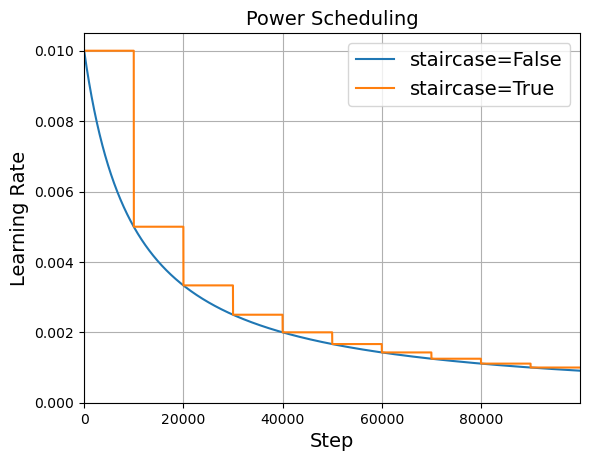

In [17]:
import numpy as np
# extra code – this cell plots power scheduling with staircase=True or False

initial_learning_rate = 0.01
decay_rate = 1.0
decay_steps = 10_000

steps = np.arange(100_000)
lrs = initial_learning_rate / (1 + decay_rate * steps / decay_steps)
lrs2 = initial_learning_rate / (1 + decay_rate * np.floor(steps / decay_steps))

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

### Exponential Scheduling

```python
learning_rate = initial_learning_rate * decay_rate ** (step / decay_steps)
```

In [19]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=20_000,
    decay_rate=0.1,
    staircase=False
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

In [20]:
history_exponential_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6756 - accuracy: 0.7669 - val_loss: 0.4877 - val_accuracy: 0.8282
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4648 - accuracy: 0.8359 - val_loss: 0.4421 - val_accuracy: 0.8406
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4209 - accuracy: 0.8511 - val_loss: 0.4080 - val_accuracy: 0.8570
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3989 - accuracy: 0.8599 - val_loss: 0.3848 - val_accuracy: 0.8630
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3814 - accuracy: 0.8668 - val_loss: 0.3800 - val_accuracy: 0.8630
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3687 - accuracy: 0.8702 - val_loss: 0.3866 - val_accuracy: 0.8648
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3604 - accuracy: 0.8720 - val_loss: 0.3678 - val_accuracy:

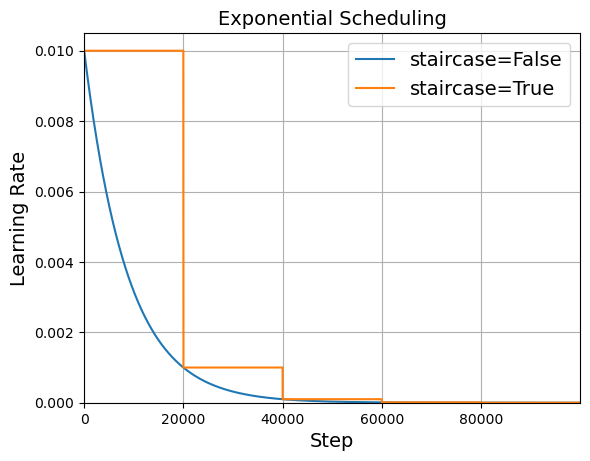

In [21]:
# extra code – this cell plots exponential scheduling

initial_learning_rate = 0.01
decay_rate = 0.1
decay_steps = 20_000

steps = np.arange(100_000)
lrs = initial_learning_rate * decay_rate ** (steps / decay_steps)
lrs2 = initial_learning_rate * decay_rate ** np.floor(steps / decay_steps)

plt.plot(steps, lrs,  "-", label="staircase=False")
plt.plot(steps, lrs2,  "-", label="staircase=True")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

Keras also provides a `LearningRateScheduler` callback class that lets you define your own scheduling function. Let's see how you could use it to implement exponential decay. Note that in this case the learning rate only changes at each epoch, not at each step:

In [22]:
def exponential_decay_fn(epoch): # <- implements the Exponential Decay learning rate as described on p.389
    return 0.01 * 0.1 ** (epoch / 20)

In [23]:
def exponential_decay(lr0, s): # <- if you don't want to hardcode the learning rate η or s
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [24]:
# extra code – build and compile a model for Fashion MNIST

tf.random.set_seed(42)
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [30]:
n_epochs = 20

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn) # <- provide the custom learning rate function callback to this callback class
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler] # <- and just provide it as a callback just like we did with the other callbacks...
)

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6881 - accuracy: 0.7665 - val_loss: 0.4926 - val_accuracy: 0.8268 - lr: 0.0089
Epoch 2/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4720 - accuracy: 0.8327 - val_loss: 0.4669 - val_accuracy: 0.8320 - lr: 0.0079
Epoch 3/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4274 - accuracy: 0.8486 - val_loss: 0.4242 - val_accuracy: 0.8482 - lr: 0.0071
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4044 - accuracy: 0.8566 - val_loss: 0.3936 - val_accuracy: 0.8562 - lr: 0.0063
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3850 - accuracy: 0.8646 - val_loss: 0.3874 - val_accuracy: 0.8572 - lr: 0.0056
Epoch 6/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3706 - accuracy: 0.8682 - val_loss: 0.3974 - val_accuracy: 0.8596 - lr: 0.0050
Epoch 7/20
1719/1719 [==============================] - 5s

Alternatively, the schedule function can take the current learning rate as a second argument:

In [25]:
def exponential_decay_fn(epoch, lr): # <- 2nd argument learning rate is optional, but you can ask for it if you want to make learning schedules based on the previous learning rate
    return lr * 0.1 ** (1 / 20)
# But if we use this we should also initialise the learning rate properly!

**Extra material**: if you want to use a custom scheduling function that updates the learning rate at each iteration rather than at each epoch, you can write your own callback class like this:

In [27]:
K = tf.keras.backend

# epoch being the full backprop step. iteration being a layer execution, I guess
class ExponentialDecay(tf.keras.callbacks.Callback):
    def __init__(self, n_steps=40_000):
        super().__init__()
        self.n_steps = n_steps

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = self.model.optimizer.learning_rate.numpy()
        new_learning_rate = lr * 0.1 ** (1 / self.n_steps)
        self.model.optimizer.learning_rate = new_learning_rate

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = self.model.optimizer.learning_rate.numpy()

In [18]:
lr0 = 0.01
model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [33]:
import math

# this is how we can implement our learning rate schedule to be updated at each step (in the sense of at each instance of the number of instances per batch)
batch_size = 32
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)
exp_decay = ExponentialDecay(n_steps)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[exp_decay]
)

Epoch 1/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2906 - accuracy: 0.8971 - val_loss: 0.3350 - val_accuracy: 0.8778 - lr: 8.9125e-05
Epoch 2/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2905 - accuracy: 0.8966 - val_loss: 0.3344 - val_accuracy: 0.8784 - lr: 7.9433e-05
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2904 - accuracy: 0.8969 - val_loss: 0.3347 - val_accuracy: 0.8782 - lr: 7.0795e-05
Epoch 4/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.2903 - accuracy: 0.8970 - val_loss: 0.3350 - val_accuracy: 0.8788 - lr: 6.3096e-05
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2901 - accuracy: 0.8973 - val_loss: 0.3348 - val_accuracy: 0.8780 - lr: 5.6234e-05
Epoch 6/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2901 - accuracy: 0.8971 - val_loss: 0.3349 - val_accuracy: 0.8788 - lr: 5.0119e-05
Epoch 7/20
1719/1719 [============

### Piecewise Constant Scheduling

In [7]:
# How to split it piecewise if not using the function setup as described in the book.
# ... this one is probably more readable.
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=[50_000, 80_000],
    values=[0.01, 0.005, 0.001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule)

2025-08-24 19:54:36.353434: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 19:54:36.361342: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 19:54:36.361368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 19:54:36.363506: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-08-24 19:54:36.363535: I tensorflow/compile

In [12]:
history_piecewise_scheduling = build_and_train_model(optimizer)  # extra code

Epoch 1/10
   1/1719 [..............................] - ETA: 15:42 - loss: 2.2371 - accuracy: 0.0625

2025-08-24 19:59:39.804312: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x785ec8038850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-08-24 19:59:39.804346: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 Laptop GPU, Compute Capability 8.9
2025-08-24 19:59:39.821607: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700
2025-08-24 19:59:39.853286: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1719/1719 [==============================] - 6s 3ms/step - loss: 0.6948 - accuracy: 0.7588 - val_loss: 0.4856 - val_accuracy: 0.8274
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4727 - accuracy: 0.8324 - val_loss: 0.4525 - val_accuracy: 0.8394
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4231 - accuracy: 0.8484 - val_loss: 0.4215 - val_accuracy: 0.8508
Epoch 4/10
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3971 - accuracy: 0.8593 - val_loss: 0.3856 - val_accuracy: 0.8604
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3756 - accuracy: 0.8656 - val_loss: 0.3743 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3589 - accuracy: 0.8709 - val_loss: 0.3822 - val_accuracy: 0.8630
Epoch 7/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3461 - accuracy: 0.8733 - val_loss: 0.3619 - val_accuracy: 0.8706
Epo

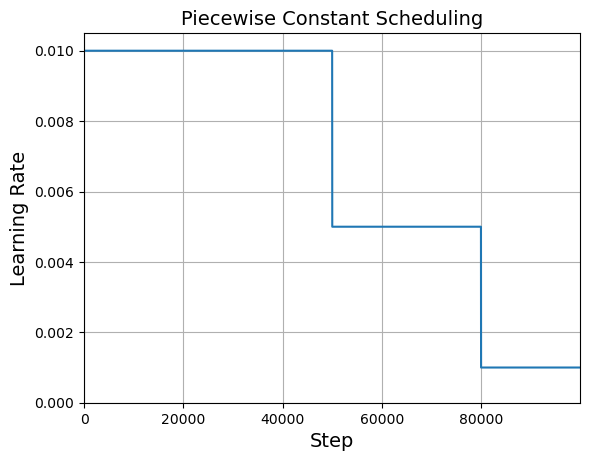

In [14]:
import numpy as np
# extra code – this cell plots piecewise constant scheduling

boundaries = [50_000, 80_000]
values = [0.01, 0.005, 0.001]

steps = np.arange(100_000)

lrs = np.full(len(steps), values[0])
for boundary, value in zip(boundaries, values[1:]):
    lrs[boundary:] = value

plt.plot(steps, lrs, "-")
plt.axis([0, steps.max(), 0, 0.0105])
plt.xlabel("Step")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

Just like we did with exponential scheduling, we could also implement piecewise constant scheduling manually:

In [ ]:
def piecewise_constant_fn(epoch): # ^^
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [ ]:
# extra code – this cell demonstrates a more general way to define
#              piecewise constant scheduling.

def piecewise_constant(boundaries, values): # <- if we want the boundaries to be controllable
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[(boundaries > epoch).argmax() - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [19]:
# extra code – use a tf.keras.callbacks.LearningRateScheduler like earlier

n_epochs = 25

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = build_model()
optimizer = tf.keras.optimizers.Nadam(learning_rate=lr0)

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=optimizer,
    metrics=["accuracy"]
)

history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler] # <- so same idea as above actually.
)

Epoch 1/25


2025-08-24 20:04:41.347769: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


1719/1719 [==============================] - 8s 4ms/step - loss: 0.5441 - accuracy: 0.8074 - val_loss: 0.4598 - val_accuracy: 0.8282 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4526 - accuracy: 0.8414 - val_loss: 0.4734 - val_accuracy: 0.8308 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4260 - accuracy: 0.8499 - val_loss: 0.4877 - val_accuracy: 0.8366 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4140 - accuracy: 0.8559 - val_loss: 0.4532 - val_accuracy: 0.8474 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4053 - accuracy: 0.8594 - val_loss: 0.4104 - val_accuracy: 0.8584 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3542 - accuracy: 0.8743 - val_loss: 0.4080 - val_accuracy: 0.8562 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 7s 4ms/step -

We've looked at `InverseTimeDecay`, `ExponentialDecay`, and `PiecewiseConstantDecay`. A few more schedulers are available in `tf.keras.optimizers.schedules`, here is the full list:

In [ ]:
for name in sorted(dir(tf.keras.optimizers.schedules)):
    if name[0] == name[0].lower():  # must start with capital letter
        continue
    scheduler_class = getattr(tf.keras.optimizers.schedules, name)
    print(f"• {name} – {scheduler_class.__doc__.splitlines()[0]}")

# ... or just use the public docs:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules

• CosineDecay – A LearningRateSchedule that uses a cosine decay with optional warmup.
• CosineDecayRestarts – A LearningRateSchedule that uses a cosine decay schedule with restarts.
• ExponentialDecay – A LearningRateSchedule that uses an exponential decay schedule.
• InverseTimeDecay – A LearningRateSchedule that uses an inverse time decay schedule.
• LearningRateSchedule – The learning rate schedule base class.
• PiecewiseConstantDecay – A LearningRateSchedule that uses a piecewise constant decay schedule.
• PolynomialDecay – A LearningRateSchedule that uses a polynomial decay schedule.


### Performance Scheduling

In [21]:
# extra code – build and compile the model

model = build_model()
optimizer = tf.keras.optimizers.SGD(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

In [22]:
# this is the learning rate scheduler that is dependent on validation error, kind of like early stopping. See p.389
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    validation_data=(X_valid, y_valid),
    callbacks=[lr_scheduler]
)

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6824 - accuracy: 0.7697 - val_loss: 0.4828 - val_accuracy: 0.8276 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4687 - accuracy: 0.8359 - val_loss: 0.4617 - val_accuracy: 0.8302 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 8s 4ms/step - loss: 0.4211 - accuracy: 0.8499 - val_loss: 0.4222 - val_accuracy: 0.8514 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3943 - accuracy: 0.8607 - val_loss: 0.3817 - val_accuracy: 0.8622 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3732 - accuracy: 0.8677 - val_loss: 0.3778 - val_accuracy: 0.8646 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3566 - accuracy: 0.8730 - val_loss: 0.3857 - val_accuracy: 0.8634 - lr: 0.0100
Epoch 7/25
1719/1719 [==============================] - 5s

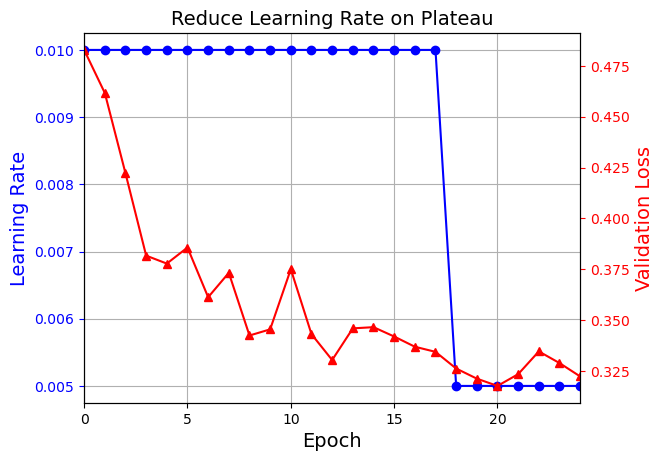

In [ ]:
# extra code – this cell plots performance scheduling

plt.plot(history.epoch, history.history["lr"], "bo-") # <- that thing is (re?) named 'lr' in my version
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce Learning Rate on Plateau", fontsize=14)
plt.show()

### 1Cycle scheduling

The `ExponentialLearningRate` custom callback updates the learning rate during training, at the end of each batch. It multiplies it by a constant `factor`. It also saves the learning rate and loss at each batch. Since `logs["loss"]` is actually the mean loss since the start of the epoch, and we want to save the batch loss instead, we must compute the mean times the number of batches since the beginning of the epoch to get the total loss so far, then we subtract the total loss at the previous batch to get the current batch's loss.

In [29]:
K = tf.keras.backend

class ExponentialLearningRate(tf.keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []

    def on_epoch_begin(self, epoch, logs=None):
        self.sum_of_epoch_losses = 0

    def on_batch_end(self, batch, logs=None):
        mean_epoch_loss = logs["loss"]  # the epoch's mean loss so far
        new_sum_of_epoch_losses = mean_epoch_loss * (batch + 1)
        batch_loss = new_sum_of_epoch_losses - self.sum_of_epoch_losses
        self.sum_of_epoch_losses = new_sum_of_epoch_losses
        lr = self.model.optimizer.learning_rate.numpy()
        self.rates.append(lr)
        self.losses.append(batch_loss)
        self.model.optimizer.learning_rate = lr * self.factor

The `find_learning_rate()` function trains the model using the `ExponentialLearningRate` callback, and it returns the learning rates and corresponding batch losses. At the end, it restores the model and its optimizer to their initial state.

In [30]:
def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=1e-4,
                       max_rate=1):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = (max_rate / min_rate) ** (1 / iterations)
    init_lr = K.get_value(model.optimizer.learning_rate)
    model.optimizer.learning_rate = min_rate
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    model.optimizer.learning_rate = init_lr
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

The `plot_lr_vs_loss()` function plots the learning rates vs the losses. The optimal learning rate to use as the maximum learning rate in 1cycle is near the bottom of the curve.

In [31]:
def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses, "b")
    plt.gca().set_xscale('log')
    max_loss = losses[0] + min(losses)
    plt.hlines(min(losses), min(rates), max(rates), color="k")
    plt.axis([min(rates), max(rates), 0, max_loss])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")
    plt.grid()

Let's build a simple Fashion MNIST model and compile it:

In [32]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              metrics=["accuracy"])

Now let's find the optimal max learning rate for 1cycle:

430/430 [==============================] - 2s 3ms/step - loss: 1.8659 - accuracy: 0.3833


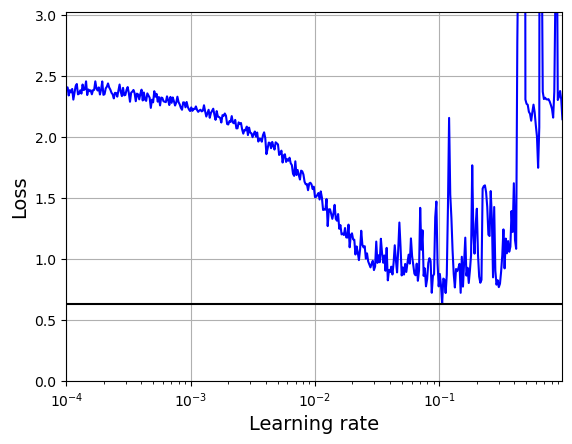

In [ ]:
import math

batch_size = 128
rates, losses = find_learning_rate(model, X_train, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

# ... The idea is at which point the loss function stops going down and starts shooting up and then use a learning rate value that occurs right before that point. Same idea as in ch.10

Looks like the max learning rate to use for 1cycle is around 10<sup>–1</sup>.

The `OneCycleScheduler` custom callback updates the learning rate at the beginning of each batch. It applies the logic described in the book: increase the learning rate linearly during about half of training, then reduce it linearly back to the initial learning rate, and lastly reduce it down to close to zero linearly for the very last part of training.

In [ ]:
# implements the last one on p.389
class OneCycleScheduler(tf.keras.callbacks.Callback):
    def __init__(self, iterations, max_lr=1e-3, start_lr=None,
                 last_iterations=None, last_lr=None):
        self.iterations = iterations
        self.max_lr = max_lr
        self.start_lr = start_lr or max_lr / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_lr = last_lr or self.start_lr / 1000
        self.iteration = 0

    def _interpolate(self, iter1, iter2, lr1, lr2):
        return (lr2 - lr1) * (self.iteration - iter1) / (iter2 - iter1) + lr1

    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            lr = self._interpolate(0, self.half_iteration, self.start_lr,
                                   self.max_lr)
        elif self.iteration < 2 * self.half_iteration:
            lr = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                   self.max_lr, self.start_lr)
        else:
            lr = self._interpolate(2 * self.half_iteration, self.iterations,
                                   self.start_lr, self.last_lr)
        self.iteration += 1
        self.model.optimizer.learning_rate = lr

Let's build and compile a simple Fashion MNIST model, then train it using the `OneCycleScheduler` callback:

In [36]:
model = build_model()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=tf.keras.optimizers.SGD(),
              metrics=["accuracy"])
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs,
                             max_lr=0.1)
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.9133 - accuracy: 0.6963 - val_loss: 0.5949 - val_accuracy: 0.7962
Epoch 2/25
430/430 [==============================] - 1s 3ms/step - loss: 0.5673 - accuracy: 0.7995 - val_loss: 0.4931 - val_accuracy: 0.8282
Epoch 3/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4970 - accuracy: 0.8250 - val_loss: 0.4873 - val_accuracy: 0.8304
Epoch 4/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4540 - accuracy: 0.8399 - val_loss: 0.4325 - val_accuracy: 0.8458
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.4253 - accuracy: 0.8483 - val_loss: 0.4176 - val_accuracy: 0.8458
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3986 - accuracy: 0.8581 - val_loss: 0.5547 - val_accuracy: 0.7930
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3852 - accuracy: 0.8607 - val_loss: 0.4077 - val_accuracy: 0.8486
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [38]:
layer = tf.keras.layers.Dense(
    100,
    activation="relu",
    kernel_initializer="he_normal",
    kernel_regularizer=tf.keras.regularizers.l2(0.01)) # <- How to use regularisation to avoid overfitting. Here we constrain the connection weights. This is added onto the final loss.
# ... Same idea as the Linear regression Regularisation chapter. See p.156 & p.393
# l2 is to constrain the connection weights.
# l1 is to make your model sparse (delete many small weights by setting them to 0)
# l1_l2 is the weighted combo of both. See p.161

# !!!! NOTE: don't use l2 with the Adam optimiser. Use AdamW which combines weight decay properly.

Or use `l1(0.1)` for ℓ<sub>1</sub> regularization with a factor of 0.1, or `l1_l2(0.1, 0.01)` for both ℓ<sub>1</sub> and ℓ<sub>2</sub> regularization, with factors 0.1 and 0.01 respectively.

In [37]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [40]:
from functools import partial

# ... how we can avoid copy-pasting repeated params a bunch of times,
# especially for regularisation since we'd presumably always want all layers
# to use the same regularisation strategy.
# (... or I guess use loops or whatever else in python)
RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01))

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax") # <- allows overriding params this way! So pretty useful
])

In [41]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2,
                    validation_data=(X_valid, y_valid))

Epoch 1/2
1719/1719 [==============================] - 5s 3ms/step - loss: 3.1502 - accuracy: 0.7698 - val_loss: 1.8675 - val_accuracy: 0.8222
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 1.4302 - accuracy: 0.8144 - val_loss: 1.1292 - val_accuracy: 0.8196


## Dropout

In [100]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [ ]:
# fun little "ensemble"-esque technique that can squeeze some extra percentage points. p.394

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2), # <- these will perform randomised dropout for the outputs from the layer right above them to the next one, only during training. This doesn't do anything after
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2), # <- ...
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2), # <- ...
    tf.keras.layers.Dense(10, activation="softmax") # the outputs themselves are never dropped! So never add Dropout after the output layer.
])

# ... in practice we can apparenly only apply it to the top 1-3 layers, excluding the output layer.

# NOTE: when we evaluate the training loss, the training loss during training may be misleading
# (the model may be overfitting the training set andd yet have similar training and validation losses)
#
#   => so: just evaluate the training loss after training (aka without dropout!) against the training set again!!!
#
# also see my notes on p.396 regarding how to deal with it overfitting/underfitting.

In [42]:
# extra code – compile and train the model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9680 - accuracy: 0.7929 - val_loss: 0.8990 - val_accuracy: 0.7942
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9069 - accuracy: 0.7993 - val_loss: 0.8920 - val_accuracy: 0.7974
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.8981 - accuracy: 0.7986 - val_loss: 0.9104 - val_accuracy: 0.7968
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8952 - accuracy: 0.7969 - val_loss: 0.8713 - val_accuracy: 0.8098
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8939 - accuracy: 0.7963 - val_loss: 0.8801 - val_accuracy: 0.7974
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8912 - accuracy: 0.7955 - val_loss: 0.9177 - val_accuracy: 0.7870
Epoch 7/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8923 - accuracy: 0.7953 - val_loss: 0.9151 - val_accuracy:

The training accuracy looks like it's lower than the validation accuracy, but that's just because dropout is only active during training. If we evaluate the model on the training set after training (i.e., with dropout turned off), we get the "real" training accuracy, which is very slightly higher than the validation accuracy and the test accuracy:

In [44]:
model.evaluate(X_train, y_train) # ^^^^

1719/1719 [==============================] - 6s 3ms/step - loss: 0.9019 - accuracy: 0.7814


[0.9018509387969971, 0.7813818454742432]

In [45]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.9252 - accuracy: 0.7713


[0.9251826405525208, 0.7713000178337097]

**Note**: make sure to use `AlphaDropout` instead of `Dropout` if you want to build a self-normalizing neural net using SELU.

## MC Dropout

In [46]:
tf.random.set_seed(42)  # extra code – for reproducibility

In [65]:
# model() allows us to re-activate the Dropout layers via training=True, and it will also return a
# tensor rather than a numpy array as the usual model.predict(X) would do
# Because we re-activate the Dropout layers, all the predictions are a bit different (randomly).
# ... So this just makes 100 predictions over the test set
y_probas = np.stack([model(X_test, training=True) for _ in range(100)])

# and this just computes the average of the 100 predictions
y_proba = y_probas.mean(axis=0) # <- more reliable predictions!

# ... refer to explanation on p.397 - p.398 (it's very clear regarding the shapes...)

In [66]:
y_probas.shape

(100, 10000, 10)

In [67]:
y_proba.shape

(10000, 10)

In [68]:
model.predict(X_test[:1]).round(3) # oops in my case i get a different result here. Might've messed something up in re-running cells. (Refer to book p.398 for the actual result)

1/1 [==============================] - 0s 10ms/step


array([[0.001, 0.002, 0.001, 0.   , 0.   , 0.16 , 0.   , 0.679, 0.021,
        0.135]], dtype=float32)

In [69]:
y_proba[0].round(3) #  yeah so my setup is messed up on these results. See p.398 again

array([0.001, 0.002, 0.001, 0.   , 0.   , 0.16 , 0.   , 0.679, 0.021,
       0.135], dtype=float32)

In [ ]:
y_std = y_probas.std(axis=0) # uh I might've messed something up here... Somehow I actually had the ones in the Monte Carlo step all predict the same value. Hence no standard deviation here.
y_std[0].round(3) # ... see book p.398 for how it's *supposed* to work.

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [ ]:
y_pred = y_proba.argmax(axis=1)
accuracy = (y_pred == y_test).sum() / len(y_test)
accuracy # my broken setup means that the accuracy ended up being bad too whoops... See above.

0.7713

In [77]:
# If we have a model that has special layers like BatchNormalization, then we shouldn't use the model(...) setup as above
# and instead provide an extended Dropout layer like this, where we override the training parameter to just be true
# (unless somebody just made a library for this already...)
# this will ensure the Dropout does not get turned off after training
class MCDropout(tf.keras.layers.Dropout):
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

In [78]:
# extra code – shows how to convert Dropout to MCDropout in a Sequential model
Dropout = tf.keras.layers.Dropout
mc_model = tf.keras.Sequential([
    MCDropout(layer.rate) if isinstance(layer, Dropout) else layer
    for layer in model.layers
])
mc_model.set_weights(model.get_weights())

In [ ]:
mc_model.summary() # somehow missing our Dropout override layers though :thinking_face: ...

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_8 (Flatten)         (None, 784)               0         
                                                                 
 dense_33 (Dense)            (None, 100)               78500     
                                                                 
 dense_34 (Dense)            (None, 100)               10100     
                                                                 
 dense_35 (Dense)            (None, 10)                1010      
                                                                 
Total params: 89610 (350.04 KB)
Trainable params: 89610 (350.04 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Now we can use the model with MC Dropout:

In [80]:
# extra code – shows that the model works without retraining
tf.random.set_seed(42)
np.mean([mc_model.predict(X_test[:1])
         for sample in range(100)], axis=0).round(2)

1/1 [==============================] - 0s 10ms/step


array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.16, 0.  , 0.68, 0.02, 0.14]],
      dtype=float32)

## Max norm

In [ ]:
dense = tf.keras.layers.Dense(
    100,
    activation="relu",
    kernel_initializer="he_normal",
    # Max norm is basically normalising the weight vector if the l2 norm gets too large. Kind of like resizing a 3D
    # vector to always be a specific size if it gets too large.
    # ALSO!! it will prevent unstable (mainly exploding) gradients too.
    # See p.400
    #
    #  bonus fact: there's also bias_constraint AND you can write your own functions that modify the constraints in some way!
    kernel_constraint=tf.keras.constraints.max_norm(1.)
)

In [116]:
# extra code – shows how to apply max norm to every hidden layer in a model

MaxNormDense = partial(tf.keras.layers.Dense,
                       activation="relu", kernel_initializer="he_normal",
                       kernel_constraint=tf.keras.constraints.max_norm(1.))

tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(100),
    MaxNormDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5500 - accuracy: 0.8015 - val_loss: 0.4510 - val_accuracy: 0.8242
Epoch 2/10
1719/1719 [==============================] - 2s 960us/step - loss: 0.4089 - accuracy: 0.8499 - val_loss: 0.3956 - val_accuracy: 0.8504
Epoch 3/10
1719/1719 [==============================] - 2s 974us/step - loss: 0.3777 - accuracy: 0.8604 - val_loss: 0.3693 - val_accuracy: 0.8680
Epoch 4/10
1719/1719 [==============================] - 2s 943us/step - loss: 0.3581 - accuracy: 0.8690 - val_loss: 0.3517 - val_accuracy: 0.8716
Epoch 5/10
1719/1719 [==============================] - 2s 949us/step - loss: 0.3416 - accuracy: 0.8729 - val_loss: 0.3433 - val_accuracy: 0.8682
Epoch 6/10
1719/1719 [==============================] - 2s 951us/step - loss: 0.3368 - accuracy: 0.8756 - val_loss: 0.4045 - val_accuracy: 0.8582
Epoch 7/10
1719/1719 [==============================] - 2s 935us/step - loss: 0.3293 - accuracy: 0.8767 - val_loss: 0.4168 - v

# Exercises

## 1. to 7.

1. Glorot initialization and He initialization were designed to make the output standard deviation as close as possible to the input standard deviation, at least at the beginning of training. This reduces the vanishing/exploding gradients problem.
2. No, all weights should be sampled independently; they should not all have the same initial value. One important goal of sampling weights randomly is to break symmetry: if all the weights have the same initial value, even if that value is not zero, then symmetry is not broken (i.e., all neurons in a given layer are equivalent), and backpropagation will be unable to break it. Concretely, this means that all the neurons in any given layer will always have the same weights. It's like having just one neuron per layer, and much slower. It is virtually impossible for such a configuration to converge to a good solution.
3. It is perfectly fine to initialize the bias terms to zero. Some people like to initialize them just like weights, and that's OK too; it does not make much difference.
4. ReLU is usually a good default for the hidden layers, as it is fast and yields good results. Its ability to output precisely zero can also be useful in some cases (e.g., see Chapter 17). Moreover, it can sometimes benefit from optimized implementations as well as from hardware acceleration. The leaky ReLU variants of ReLU can improve the model's quality without hindering its speed too much compared to ReLU. For large neural nets and more complex problems, GLU, Swish and Mish can give you a slightly higher quality model, but they have a computational cost. The hyperbolic tangent (tanh) can be useful in the output layer if you need to output a number in a fixed range (by default between –1 and 1), but nowadays it is not used much in hidden layers, except in recurrent nets. The sigmoid activation function is also useful in the output layer when you need to estimate a probability (e.g., for binary classification), but it is rarely used in hidden layers (there are exceptions—for example, for the coding layer of variational autoencoders; see Chapter 17). The softplus activation function is useful in the output layer when you need to ensure that the output will always be positive. The softmax activation function is useful in the output layer to estimate probabilities for mutually exclusive classes, but it is rarely (if ever) used in hidden layers.
5. If you set the `momentum` hyperparameter too close to 1 (e.g., 0.99999) when using an `SGD` optimizer, then the algorithm will likely pick up a lot of speed, hopefully moving roughly toward the global minimum, but its momentum will carry it right past the minimum. Then it will slow down and come back, accelerate again, overshoot again, and so on. It may oscillate this way many times before converging, so overall it will take much longer to converge than with a smaller `momentum` value.
6. One way to produce a sparse model (i.e., with most weights equal to zero) is to train the model normally, then zero out tiny weights. For more sparsity, you can apply ℓ<sub>1</sub> regularization during training, which pushes the optimizer toward sparsity. A third option is to use the TensorFlow Model Optimization Toolkit.
7. Yes, dropout does slow down training, in general roughly by a factor of two. However, it has no impact on inference speed since it is only turned on during training. MC Dropout is exactly like dropout during training, but it is still active during inference, so each inference is slowed down slightly. More importantly, when using MC Dropout you generally want to run inference 10 times or more to get better predictions. This means that making predictions is slowed down by a factor of 10 or more.

## 8. Deep Learning on CIFAR10

### a.
*Exercise: Build a DNN with 20 hidden layers of 100 neurons each (that's too many, but it's the point of this exercise). Use He initialization and the Swish activation function.*

In [117]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal"))

### b.
*Exercise: Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

Let's add the output layer to the model:

In [118]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [119]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [120]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

Now we can create the callbacks we need and train the model:

In [121]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [122]:
%load_ext tensorboard
%tensorboard --logdir=./my_cifar10_logs

In [123]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 [==============================] - 17s 10ms/step - loss: 4.0462 - accuracy: 0.1597 - val_loss: 2.1441 - val_accuracy: 0.2036
Epoch 2/100
1407/1407 [==============================] - 12s 9ms/step - loss: 2.0667 - accuracy: 0.2320 - val_loss: 2.0134 - val_accuracy: 0.2472
Epoch 3/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.9472 - accuracy: 0.2819 - val_loss: 1.9427 - val_accuracy: 0.2796
Epoch 4/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.8637 - accuracy: 0.3182 - val_loss: 1.8934 - val_accuracy: 0.3222
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.7974 - accuracy: 0.3465 - val_loss: 1.8389 - val_accuracy: 0.3284
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 1.7446 - accuracy: 0.3664 - val_loss: 2.0006 - val_accuracy: 0.3030
Epoch 7/100
1407/1407 [==============================] - 12s 8ms/step - loss: 1.6974 - accuracy: 0.3852 - val_loss: 1.707

In [124]:
model.evaluate(X_valid, y_valid)

157/157 [==============================] - 0s 2ms/step - loss: 1.5062 - accuracy: 0.4676


[1.5061508417129517, 0.4675999879837036]

The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

### c.
*Exercise: Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

The code below is very similar to the code above, with a few changes:

* I added a BN layer after every Dense layer (before the activation function), except for the output layer.
* I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5, 5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the best validation performance after 20 epochs.
* I renamed the run directories to run_bn_* and the model file name to `my_cifar10_bn_model`.

In [125]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

Epoch 1/100
1407/1407 [==============================] - 32s 18ms/step - loss: 2.0374 - accuracy: 0.2525 - val_loss: 1.8766 - val_accuracy: 0.3154
Epoch 2/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.7874 - accuracy: 0.3542 - val_loss: 1.8784 - val_accuracy: 0.3268
Epoch 3/100
1407/1407 [==============================] - 20s 15ms/step - loss: 1.6806 - accuracy: 0.3969 - val_loss: 1.9764 - val_accuracy: 0.3252
Epoch 4/100
1407/1407 [==============================] - 24s 17ms/step - loss: 1.6112 - accuracy: 0.4228 - val_loss: 1.7087 - val_accuracy: 0.3750
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 1.5521 - accuracy: 0.4476 - val_loss: 1.6272 - val_accuracy: 0.4176
Epoch 6/100
1407/1407 [==============================] - 23s 16ms/step - loss: 1.5030 - accuracy: 0.4660 - val_loss: 1.5401 - val_accuracy: 0.4452
Epoch 7/100
1407/1407 [==============================] - 15s 11ms/step - loss: 1.4559 - accuracy: 0.4812 - val_loss: 1

[1.4236289262771606, 0.5073999762535095]

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

### d.
*Exercise: Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [126]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model.keras", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 20s 13ms/step - loss: 1.9385 - accuracy: 0.3046 - val_loss: 1.8175 - val_accuracy: 0.3510
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.7241 - accuracy: 0.3869 - val_loss: 1.7677 - val_accuracy: 0.3614
Epoch 3/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.6272 - accuracy: 0.4263 - val_loss: 1.6878 - val_accuracy: 0.4054
Epoch 4/100
1407/1407 [==============================] - 18s 13ms/step - loss: 1.5643 - accuracy: 0.4492 - val_loss: 1.6589 - val_accuracy: 0.4304
Epoch 5/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5080 - accuracy: 0.4712 - val_loss: 1.5651 - val_accuracy: 0.4538
Epoch 6/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4613 - accuracy: 0.4872 - val_loss: 1.5305 - val_accuracy: 0.4678
Epoch 7/100
1407/1407 [==============================] - 17s 12ms/step - loss: 1.4174 - accuracy: 0.5077 - val_loss: 1

[1.4607702493667603, 0.5026000142097473]

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

### e.
*Exercise: Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.*

**Warning**: there are now two versions of `AlphaDropout`. One is deprecated and also broken in some recent versions of TF, and unfortunately that's the version in the `tensorflow` library. Luckily, there's a perfectly fine version in the `keras` library (i.e., `keras`, not `tf.keras`). It's neither deprecated nor broken, so let's import and use that one:

In [127]:
import keras.layers

In [128]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model.keras", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

Epoch 1/100
1407/1407 [==============================] - 18s 11ms/step - loss: 1.8950 - accuracy: 0.3239 - val_loss: 1.7556 - val_accuracy: 0.3812
Epoch 2/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.6618 - accuracy: 0.4130 - val_loss: 1.6563 - val_accuracy: 0.4114
Epoch 3/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.5770 - accuracy: 0.4432 - val_loss: 1.6507 - val_accuracy: 0.4232
Epoch 4/100
1407/1407 [==============================] - 15s 10ms/step - loss: 1.5081 - accuracy: 0.4672 - val_loss: 1.5892 - val_accuracy: 0.4566
Epoch 5/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.4561 - accuracy: 0.4902 - val_loss: 1.5382 - val_accuracy: 0.4696
Epoch 6/100
1407/1407 [==============================] - 16s 11ms/step - loss: 1.4094 - accuracy: 0.5050 - val_loss: 1.5236 - val_accuracy: 0.4818
Epoch 7/100
1407/1407 [==============================] - 14s 10ms/step - loss: 1.3636 - accuracy: 0.5232 - val_loss: 1

[1.4779616594314575, 0.498199999332428]

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [129]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [130]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [131]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [132]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

0.4984

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [133]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.1706


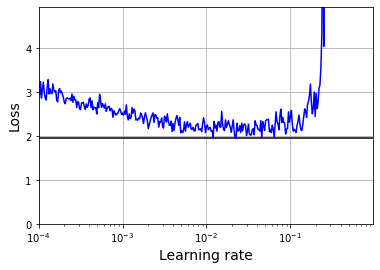

In [134]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [135]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [136]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0559 - accuracy: 0.2839 - val_loss: 1.7917 - val_accuracy: 0.3768
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.7596 - accuracy: 0.3797 - val_loss: 1.6566 - val_accuracy: 0.4258
Epoch 3/15
352/352 [==============================] - 3s 8ms/step - loss: 1.6199 - accuracy: 0.4247 - val_loss: 1.6395 - val_accuracy: 0.4260
Epoch 4/15
352/352 [==============================] - 3s 9ms/step - loss: 1.5451 - accuracy: 0.4524 - val_loss: 1.6202 - val_accuracy: 0.4408
Epoch 5/15
352/352 [==============================] - 3s 8ms/step - loss: 1.4952 - accuracy: 0.4691 - val_loss: 1.5981 - val_accuracy: 0.4488
Epoch 6/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4541 - accuracy: 0.4842 - val_loss: 1.5720 - val_accuracy: 0.4490
Epoch 7/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4171 - accuracy: 0.4967 - val_loss: 1.6035 - val_accuracy: 0.4470
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).